
# PA Project Phase 4 – Model Evaluation and Hyperparameter Tuning

This notebook follows CRISP-DM step 5 for model evaluation. We work with the provided health screening dataset (`smoking.csv`) to predict smoking status. Each code cell includes notes explaining what is happening and why.



## 1. Setup
Import core libraries for data handling, visualization, and modeling.


In [1]:

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)  # keep output clean while retaining reproducibility

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    hamming_loss,
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

sns.set(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (10, 6)



## 2. Load and inspect data
Read the CSV, preview rows, and check basic info to understand types and potential cleaning steps.

## Source file
https://www.kaggle.com/datasets/kukuroo3/body-signal-of-smoking


In [2]:

df = pd.read_csv("dataset/smoking.csv")

display(df.head())
df.info()


,ID,gender,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),...,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,oral,dental caries,tartar,smoking
0,0,F,40,155,60,81.3,1.2,1.0,1.0,1.0,...,12.9,1.0,0.7,18.0,19.0,27.0,Y,0,Y,0
1,1,F,40,160,60,81.0,0.8,0.6,1.0,1.0,...,12.7,1.0,0.6,22.0,19.0,18.0,Y,0,Y,0
2,2,M,55,170,60,80.0,0.8,0.8,1.0,1.0,...,15.8,1.0,1.0,21.0,16.0,22.0,Y,0,N,1
3,3,M,40,165,70,88.0,1.5,1.5,1.0,1.0,...,14.7,1.0,1.0,19.0,26.0,18.0,Y,0,Y,0
4,4,F,40,155,60,86.0,1.0,1.0,1.0,1.0,...,12.5,1.0,0.6,16.0,14.0,22.0,Y,0,N,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55692 entries, 0 to 55691
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   55692 non-null  int64  
 1   gender               55692 non-null  object 
 2   age                  55692 non-null  int64  
 3   height(cm)           55692 non-null  int64  
 4   weight(kg)           55692 non-null  int64  
 5   waist(cm)            55692 non-null  float64
 6   eyesight(left)       55692 non-null  float64
 7   eyesight(right)      55692 non-null  float64
 8   hearing(left)        55692 non-null  float64
 9   hearing(right)       55692 non-null  float64
 10  systolic             55692 non-null  float64
 11  relaxation           55692 non-null  float64
 12  fasting blood sugar  55692 non-null  float64
 13  Cholesterol          55692 non-null  float64
 14  triglyceride         55692 non-null  float64
 15  HDL                  55692 non-null 


## 3. Clean and prepare features
- Encode categorical variables (gender, oral exam flags) as numeric.
- Drop the ID column since it is an identifier only.
- Verify there are no missing values after encoding.


In [3]:

# Encode binary flags
binary_cols = ["oral", "dental caries", "tartar"]
df[binary_cols] = df[binary_cols].replace({"Y": 1, "N": 0}).astype(int)

# Encode gender and target
df["gender"] = df["gender"].map({"F": 0, "M": 1}).astype(int)
df["smoking"] = df["smoking"].astype(int)

# Drop identifier column
if "ID" in df.columns:
    df = df.drop(columns=["ID"])

# Check for missing values
missing_summary = df.isna().sum()
missing_summary[missing_summary > 0]


Series([], dtype: int64)


## 4. Exploratory checks
Quick descriptive statistics to understand distributions and detect potential scale differences.


In [4]:

df.describe().T


,count,mean,std,min,25%,50%,75%,max
gender,55692.0,0.635657,0.481250,0.0,0.0,1.0,1.0,1.0
age,55692.0,44.182917,12.071418,20.0,40.0,40.0,55.0,85.0
height(cm),55692.0,164.649321,9.194597,130.0,160.0,165.0,170.0,190.0
weight(kg),55692.0,65.864936,12.820306,30.0,55.0,65.0,75.0,135.0
waist(cm),55692.0,82.046418,9.274223,51.0,76.0,82.0,88.0,129.0
eyesight(left),55692.0,1.012623,0.486873,0.1,0.8,1.0,1.2,9.9
eyesight(right),55692.0,1.007443,0.485964,0.1,0.8,1.0,1.2,9.9
hearing(left),55692.0,1.025587,0.157902,1.0,1.0,1.0,1.0,2.0
hearing(right),55692.0,1.026144,0.159564,1.0,1.0,1.0,1.0,2.0
systolic,55692.0,121.494218,13.675989,71.0,112.0,120.0,130.0,240.0



## 5. Train-test split
Use a stratified split to preserve smoking/non-smoking ratio. Standardize features inside pipelines where needed.


In [5]:

X = df.drop(columns=["smoking"])
y = df["smoking"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train.shape, X_test.shape


((44553, 25), (11139, 25))


## 6. Helper: model training and evaluation
Function to fit a model, generate predictions, and compute assignment-required metrics.


In [6]:

def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    proba = model.predict_proba(X_test)[:, 1]

    results = {
        "model": name,
        "accuracy": accuracy_score(y_test, preds),
        "roc_auc": roc_auc_score(y_test, proba),
        "precision": precision_score(y_test, preds),
        "recall": recall_score(y_test, preds),
        "hamming_loss": hamming_loss(y_test, preds),
        "confusion_matrix": confusion_matrix(y_test, preds),
        "preds": preds,
        "proba": proba,
    }
    return results



## 7. Baseline models
Train three diverse classifiers:
1. Logistic Regression (linear baseline)
2. Random Forest (tree ensemble)
3. Gradient Boosting (boosted trees)

Pipelines ensure scaling where appropriate.


In [7]:

models = {
    "Logistic Regression": Pipeline(
        steps=[("scaler", StandardScaler()), ("clf", LogisticRegression(max_iter=500))]
    ),
    "Random Forest": Pipeline(
        steps=[
            (
                "clf",
                RandomForestClassifier(
                    n_estimators=250,
                    max_depth=None,
                    min_samples_leaf=2,
                    random_state=42,
                ),
            )
        ]
    ),
    "Gradient Boosting": Pipeline(
        steps=[("clf", GradientBoostingClassifier(random_state=42))]
    ),
}

results = []
for name, model in models.items():
    res = evaluate_model(name, model, X_train, X_test, y_train, y_test)
    results.append(res)

metrics_df = (
    pd.DataFrame(results)[
        ["model", "accuracy", "roc_auc", "precision", "recall", "hamming_loss"]
    ]
    .set_index("model")
    .sort_values(by="roc_auc", ascending=False)
)
metrics_df


,accuracy,roc_auc,precision,recall,hamming_loss
model,,,,,
Random Forest,0.830505,0.913145,0.754329,0.798582,0.169495
Gradient Boosting,0.767932,0.848241,0.671059,0.722073,0.232068
Logistic Regression,0.746297,0.828251,0.640337,0.705451,0.253703



## 8. Visualize ROC curves and confusion matrices
Compare discrimination via ROC curves and inspect error patterns via confusion matrices for each model.


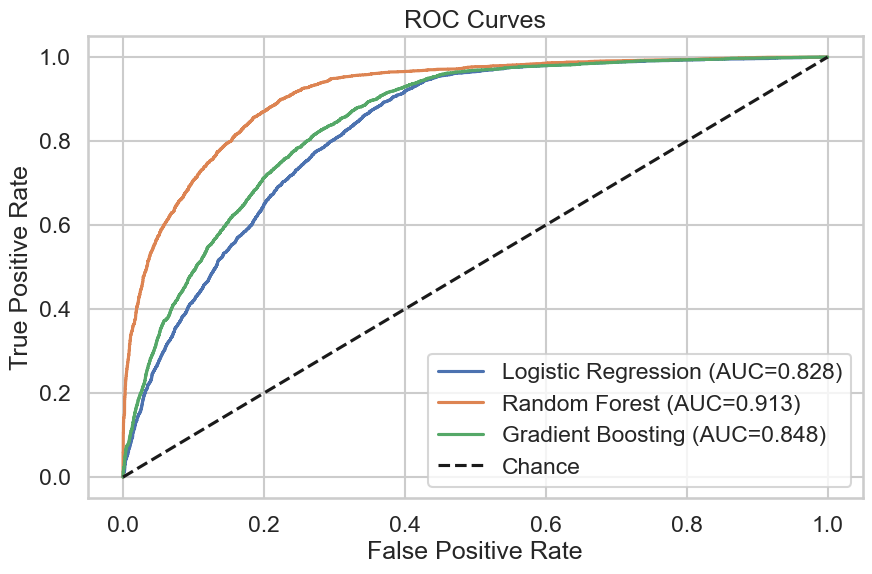

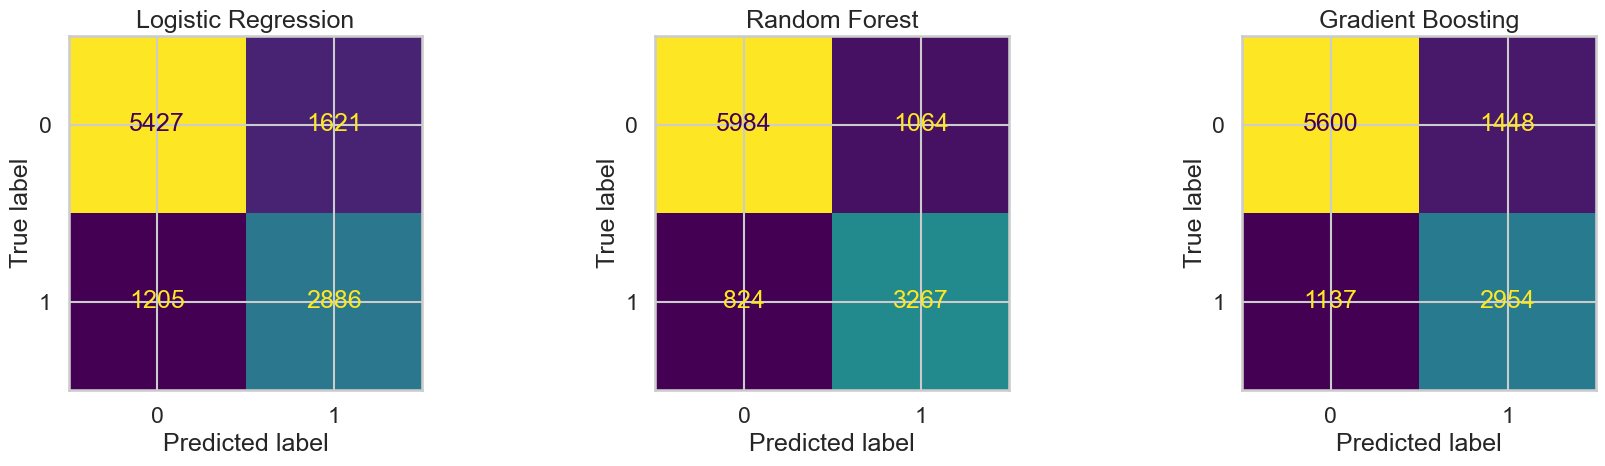

In [8]:

fig, ax = plt.subplots()
for res in results:
    fpr, tpr, _ = metrics.roc_curve(y_test, res["proba"])
    ax.plot(fpr, tpr, label=f"{res['model']} (AUC={res['roc_auc']:.3f})")
ax.plot([0, 1], [0, 1], "k--", label="Chance")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curves")
ax.legend()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, res in zip(axes, results):
    ConfusionMatrixDisplay(res["confusion_matrix"]).plot(ax=ax, colorbar=False)
    ax.set_title(res["model"])
plt.tight_layout()
plt.show()



### 8.5 Metric interpretation (business perspective)
- **Accuracy**: overall hit rate; good when classes balanced but can hide false negatives.
- **ROC-AUC**: probability the model ranks a smoker higher than a non-smoker; robust to threshold choice.
- **Precision**: of predicted smokers, how many are true smokers (controls false positive outreach).
- **Recall**: share of actual smokers detected (captures screening coverage).
- **Confusion matrix**: shows false positives vs false negatives explicitly for stakeholder discussion.
- **Hamming loss**: fraction of misclassified cases; lower is better and complements accuracy.



## 9. Select best model for tuning
Pick the model with the highest ROC-AUC (and strong accuracy) for further improvement.


In [9]:

best_entry = max(results, key=lambda r: r["roc_auc"])
best_entry["model"]


'Random Forest'


## 10. Hyperparameter tuning
Apply randomized search to the top model from above to explore a richer parameter space. We score using ROC-AUC to align with the evaluation goal. For very large datasets we optionally subsample for tuning to keep runtime reasonable.


In [10]:

# Optional downsample for faster tuning on very large training sets
sample_size = 40000
if len(X_train) > sample_size:
    tune_df = pd.concat([X_train, y_train], axis=1).sample(sample_size, random_state=42)
    tune_X = tune_df.drop(columns=["smoking"])
    tune_y = tune_df["smoking"]
else:
    tune_X, tune_y = X_train, y_train

if best_entry["model"] == "Gradient Boosting":
    base_clf = GradientBoostingClassifier(random_state=42)
    param_dist = {
        "n_estimators": [100, 200, 300],
        "learning_rate": [0.03, 0.07, 0.1, 0.2],
        "max_depth": [2, 3],
        "min_samples_leaf": [1, 2, 4],
    }
    tuned_pipe = Pipeline([("clf", base_clf)])
elif best_entry["model"] == "Random Forest":
    base_clf = RandomForestClassifier(random_state=42)
    param_dist = {
        "n_estimators": [150, 300, 450],
        "max_depth": [None, 12, 24],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "max_features": ["sqrt", "log2"],
    }
    tuned_pipe = Pipeline([("clf", base_clf)])
else:  # Logistic Regression
    base_clf = LogisticRegression(max_iter=1000)
    param_dist = {
        "clf__C": np.logspace(-3, 2, 8),
        "clf__penalty": ["l2"],
        "clf__solver": ["lbfgs"],
    }
    tuned_pipe = Pipeline([("scaler", StandardScaler()), ("clf", base_clf)])

param_grid = {f"clf__{k}": v for k, v in param_dist.items()} if best_entry["model"] != "Logistic Regression" else param_dist

search = RandomizedSearchCV(
    tuned_pipe,
    param_grid,
    n_iter=8,
    cv=3,
    scoring="roc_auc",
    random_state=42,
    n_jobs=-1,
)

search.fit(tune_X, tune_y)
search.best_params_, search.best_score_


({'clf__n_estimators': 450,
  'clf__min_samples_split': 2,
  'clf__min_samples_leaf': 1,
  'clf__max_features': 'log2',
  'clf__max_depth': None},
 np.float64(0.8921686412688548))


## 11. Evaluate tuned model
Compare tuned performance against the original best baseline.


In [11]:

tuned_res = evaluate_model(
    f"{best_entry['model']} (tuned)", search.best_estimator_, X_train, X_test, y_train, y_test
)

comparison = metrics_df.copy()
comparison.loc[tuned_res["model"]] = [
    tuned_res["accuracy"],
    tuned_res["roc_auc"],
    tuned_res["precision"],
    tuned_res["recall"],
    tuned_res["hamming_loss"],
]
comparison = comparison.sort_values("roc_auc", ascending=False)
comparison


,accuracy,roc_auc,precision,recall,hamming_loss
model,,,,,
Random Forest (tuned),0.834007,0.919026,0.757820,0.805427,0.165993
Random Forest,0.830505,0.913145,0.754329,0.798582,0.169495
Gradient Boosting,0.767932,0.848241,0.671059,0.722073,0.232068
Logistic Regression,0.746297,0.828251,0.640337,0.705451,0.253703



### 11.5 Tuning takeaway
- `search.best_params_` summarises the strongest hyperparameter combination.
- `search.best_score_` is the mean CV ROC-AUC during tuning; the comparison table above shows the generalization scores on the held-out test set.
- Improvement focus: ROC-AUC (ranking quality) first, then accuracy/recall to ensure coverage of smokers while keeping false alerts reasonable.



## 12. Conclusions
- Report which model performed best and how tuning affected results.
- Highlight key metrics required by the assignment: accuracy, ROC-AUC, precision, recall, confusion matrix, and hamming loss.
- Note reproducibility choices (random seeds, documented pipeline).
